In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src.downsample import downsamp_audio
import src.dimension_reducer as dr
import src.distance_metrics as dm
import src.emb_manipulator as em

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#Directory where already-generated embeddings stored
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models. in any "all models" script we evaluate which one(s) might be best

##files starting with 020422 are from the recent recordings of actual moms sohye sent
## files starting with 020322 were all the test recordings from last year

#the directory has other csvs and i only want today's
#file = [file for file in os.listdir(embedding_dir) if file.startswith("020422")] 
#file = '022822_postpartum_moms_20part_emb_ami.csv'
file = '03016_diarized_pyv2.csv'

#create a dictionary where each item is the pd df of the embeddings extracted from that model
#all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}
emb = pd.read_csv(os.path.join(embedding_dir,file), index_col=0)

#choose 'emb_ami' as the embedding model to use because it seemed to result in best preserved high-dimension structure when dimension reduced
#emb = all_embs[emb_models[0]]
emb_down_unscaled = em.resample_data(emb,1)

#average emebdding for each participant
emb_a = em.embedding_averager(emb_down_unscaled)

#egemap (88 features) for each participant
#gemap_file = '040122_segmented_postpartum_moms_gemaps'
gemap_file = '040122_segmented_postpartum_moms_gemaps_2sec.csv'
#gemap_file = '040622_segmented_postpartum_moms_gemaps_5sec.csv'
gemap_unscaled = pd.read_csv(os.path.join(embedding_dir,gemap_file), index_col=0)
gemap_unscaled = gemap_unscaled.drop(columns=['start','end'])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(emb_down_unscaled.drop(columns='part_id'))
emb_down = pd.DataFrame(scaler.transform(emb_down_unscaled.drop(columns='part_id')))
emb_down['part_id'] = emb_down_unscaled.part_id.to_numpy()

scaler_gemap = StandardScaler()
scaler_gemap.fit(gemap_unscaled.drop(columns='part_id'))
gemap = pd.DataFrame(scaler_gemap.transform(gemap_unscaled.drop(columns='part_id')))
gemap['part_id'] = gemap_unscaled.part_id.to_numpy()

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
test_subset_labeled = emb_down.groupby('part_id').sample(n=5, random_state=42)
train_subset_labeled = emb_down.drop(test_subset_labeled.index)

#train = train_subset_labeled.reset_index(drop=True).drop(columns='part_id')
train = train_subset_labeled.drop(columns='part_id').to_numpy()
train_labels = train_subset_labeled.part_id.to_numpy()

#test = test_subset_labeled.reset_index(drop=True).drop(columns='part_id')
test = test_subset_labeled.drop(columns='part_id').to_numpy()
test_labels = test_subset_labeled.part_id.to_numpy()

#all_data = np.array(np.vstack([train, test]), dtype=np.float64)
#target = np.hstack([train_labels, test_labels])
#classes = emb_down.part_id.unique().astype('int32')

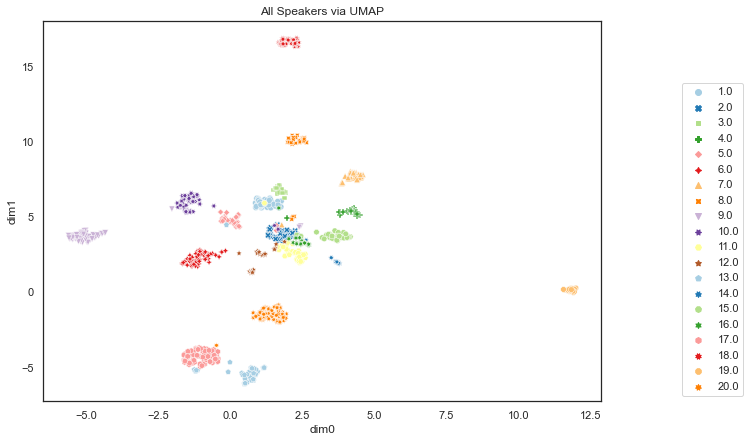

In [4]:
import umap

embedding = umap.UMAP(n_neighbors=10).fit_transform(emb_down.drop(columns='part_id'))
embedding = pd.DataFrame(embedding, columns={'dim0', 'dim1'})
embedding['part_id'] = emb_down['part_id'].to_numpy()

fig, ax = plt.subplots(1, figsize=(10, 7))
sns.scatterplot(x = embedding.dim0, y = embedding.dim1, palette="Paired", hue=embedding.part_id, style=embedding.part_id, legend=True)
ax.legend(loc="lower center",bbox_to_anchor=(1.2,0), ncol=1)
plt.title('All Speakers via UMAP');


In [5]:
mapper = umap.UMAP(n_neighbors=10).fit(train, train_labels)
train_embedding = mapper.embedding_
train_embedding = pd.DataFrame(train_embedding, columns={'dim0','dim1'})
train_embedding['part_id'] = train_labels

test_embedding = mapper.transform(test)
test_embedding = pd.DataFrame(test_embedding, columns={'dim0','dim1'})
test_embedding['part_id'] = test_labels

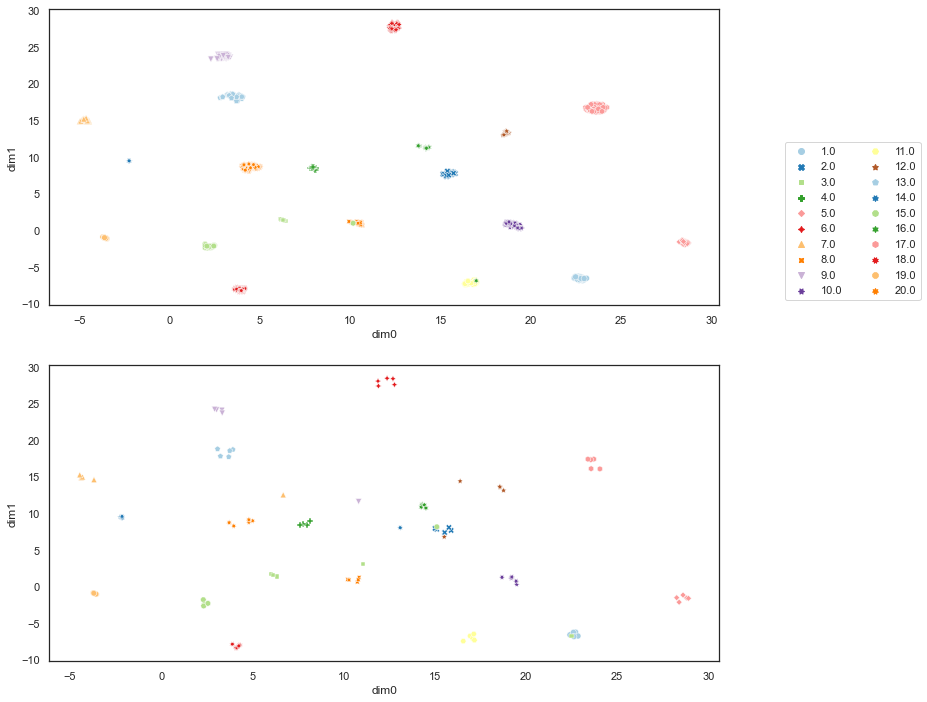

In [6]:
fig, ((ax1, ax2)) = plt.subplots(figsize=(12,12), nrows=2)

train_plot = sns.scatterplot(x=train_embedding.dim0, y=train_embedding.dim1, 
                                 ax=ax1, palette="Paired", hue=train_embedding.part_id, style=train_embedding.part_id, legend=True)

#metric_learn_train = sns.scatterplot(x=train_embedding.dim0, y=train_embedding.dim1, 
#                                ax=ax2, palette="Paired", hue=train_embedding.part_id, style=train_labels, legend=False)

metric_learn_test = sns.scatterplot(x=test_embedding.dim0, y=test_embedding.dim1, 
                                 ax=ax2, palette="Paired", hue=test_embedding.part_id, style=test_embedding.part_id, legend=False)
ax1.legend(loc="lower center",bbox_to_anchor=(1.2, 0), ncol=2)

In [7]:
train_haus = dm.hausdorff_distances(train_embedding)
#metric_learning_haus = dm.hausdorff_distances(pd.concat([train_embedding, test_embedding]))
metric_learning_haus = dm.hausdorff_distances(pd.concat([test_embedding,train_embedding]))
all_data_haus = dm.hausdorff_distances(embedding)

Processing row 19, col 19


In [8]:
corr_coeff = pd.DataFrame()
df_1 = pd.DataFrame(train_haus.to_numpy().flatten()).dropna()
df_2 = pd.DataFrame(metric_learning_haus.to_numpy().flatten()).dropna()

df_1.corrwith(df_2)

0    0.886883
dtype: float64

<AxesSubplot:>

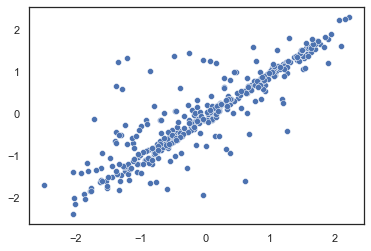

In [9]:
sns.scatterplot(x=train_haus.to_numpy().flatten(), y=metric_learning_haus.to_numpy().flatten()) 

In [10]:
high_dim = emb_down.drop(columns='part_id').to_numpy()
labels= emb_down.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = embedding
dist_umap = dm.embedding_quality(high_dim, low_dim, labels,subsetsize=emb_down.shape[0])

#metric learned comparison
low_dim = np.vstack((test_embedding,mapper.embedding_))
dist_umap_metric_learn = dm.embedding_quality(high_dim, low_dim, labels,subsetsize=emb_down.shape[0])

#of just the training data (before adding in the new speaker)
high_dim = train_data
low_dim = train_embedding
dist_umap_train_data = dm.embedding_quality(high_dim, low_dim, train_labels,subsetsize=train_data.shape[0])


TypeError: '(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False]), slice(None, None, None))' is an invalid key

In [11]:
np.vstack((dist_umap,dist_umap_metric_learn, dist_umap_train_data))

NameError: name 'dist_umap' is not defined